In [1]:
import numpy as np
from qiskit import Aer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.opflow import StateFn, Z, I, CircuitSampler, Gradient, Hessian
from qiskit.algorithms.optimizers import GradientDescent
import matplotlib.pyplot as plt

In [2]:
# Code to generate a circuit as present in the paper
def paper_circuit():
    circuit = QuantumCircuit(5)
    params = ParameterVector("theta", length=5)
    for i in range(5):
        circuit.rx(params[i], i)
    circuit.cx(0, 1)
    circuit.cx(2, 1)
    circuit.cx(3, 1)
    circuit.cx(4, 3)
    hamiltonian = I
    for i in range(1, 5):
        if i == 3:
            hamiltonian = hamiltonian ^ Z
        else:
            hamiltonian = hamiltonian ^ I
    readout_operator = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    return circuit, readout_operator
print(paper_circuit()[0])

     ┌──────────────┐                    
q_0: ┤ Rx(theta[0]) ├──■─────────────────
     ├──────────────┤┌─┴─┐┌───┐┌───┐     
q_1: ┤ Rx(theta[1]) ├┤ X ├┤ X ├┤ X ├─────
     ├──────────────┤└───┘└─┬─┘└─┬─┘     
q_2: ┤ Rx(theta[2]) ├───────■────┼───────
     ├──────────────┤            │  ┌───┐
q_3: ┤ Rx(theta[3]) ├────────────■──┤ X ├
     ├──────────────┤               └─┬─┘
q_4: ┤ Rx(theta[4]) ├─────────────────■──
     └──────────────┘                    


In [3]:
def evaluate_expectation(x):
    value_dict = dict(zip(circuit.parameters, x))
    result = sampler.convert(op, params=value_dict).eval()  
    return np.real(result)

def evaluate_gradient(x):
    value_dict = dict(zip(circuit.parameters, x))
    result = sampler.convert(gradient, params=value_dict).eval()
    return np.real(result)

def gd_callback(nfevs, x, fx, stepsize):
    #if nfevs % 10 == 0:
    #    print(nfevs, fx)
    #print(nfevs, fx)
    gd_loss.append(fx)
    x_values.append([x[0], x[1]])

In [4]:
simulate = True
provider = IBMQ.load_account()
if simulate:
    backend = Aer.get_backend('aer_simulator')
else:
    backend = provider.backends(name='ibmq_belem')[0]

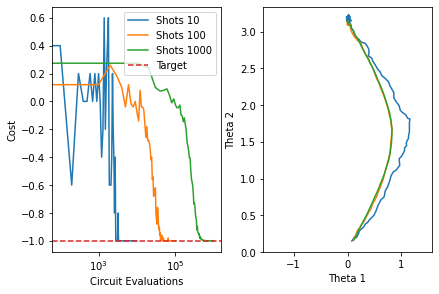

In [5]:
initial_point = np.random.uniform(0, 2 * np.pi, 5)


shots = [10, 100, 1000]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()
for s in shots:
    # Create circuit
    circuit, op = paper_circuit()
    # Specify backend information
    q_instance = QuantumInstance(backend, shots=s)
    sampler = CircuitSampler(q_instance)
    gradient = Gradient(grad_method='param_shift').convert(op)
    gd_loss, x_values = [], []
    # Create optimizer
    gd = GradientDescent(maxiter=100, learning_rate=0.1, tol=1e-4, callback=gd_callback)
    # Minimize function
    gd.optimize(initial_point.size, evaluate_expectation, gradient_function=evaluate_gradient, initial_point=initial_point) 
    # Plotting information
    cir_evals = np.array([i for i in range(len(gd_loss))])
    cir_evals *= (2 * circuit.num_parameters * s)
    ax1.plot(cir_evals, gd_loss, label='Shots %d'%s)
    x_values.clear()
    # Keeping track of just theta_0 and theta_1
    gd.optimize(initial_point.size, evaluate_expectation, gradient_function=evaluate_gradient, \
                initial_point=[0.1, 0.15, 0, 0, 0]) 
    x_values = np.array(x_values)
    ax2.plot(x_values[:,0], x_values[:,1], label='Shots %d'%s)

# Make the graph look nice
ax1.axhline(-1, ls='--', c='tab:red', label='Target')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Circuit Evaluations')
ax1.set_xscale('log')
ax1.legend()
ax2.set_ylim(0, np.pi + 0.2)
ax2.set_xlim(-np.pi/2, np.pi/2)
ax2.set_ylabel('Theta 2')
ax2.set_xlabel('Theta 1')
#ax2.legend()
plt.show()

In [6]:
class NewtonOpt(object):
    def __init__(self, hess, grad, num_param, circuit, sampler, op, init, lr=0.1, s=1000, maxiter=100):
        self.lr = lr
        self.shots = s
        self.hess = hess
        self.grad = grad
        self.max_iter = maxiter
        self.num_params = num_param
        self.circuit = circuit
        self.sampler = sampler
        self.op = op
        self.values = []
        self.circuit_evals = []
        self.init = init 

    def optimize(self):
        x = self.init
        for i in range(self.max_iter):
            value_dict = dict(zip(self.circuit.parameters, x))
            result = np.real(self.sampler.convert(self.op, params=value_dict).eval())
            self.values.append(result)
            value_dict = dict(zip(self.circuit.parameters, x))
            hessian = np.real(self.sampler.convert(self.hess, params=value_dict).eval())
            gradient = np.real(self.sampler.convert(self.grad, params=value_dict).eval())
            x = x - self.lr * np.linalg.inv(hessian + np.eye(self.num_params)) @ gradient
            #if i % 10 == 0:
            #    print(i, result)
        return self.values, np.array([i for i in range(len(self.values))]) * \
                    ((4 * self.num_params**2 - 3 * self.num_params) * self.shots)

In [7]:
# Generate circuit with only two parameters
def paper_circuit_two_param():
    circuit = QuantumCircuit(5) # 5 qubit circuit
    params = ParameterVector("theta", length=2)
    for i in range(2):
        circuit.rx(params[i], i)
    circuit.cx(0, 1)
    circuit.cx(2, 1)
    circuit.cx(3, 1)
    circuit.cx(4, 3)
    hamiltonian = I
    for i in range(1, 5):
        if i == 3:
            hamiltonian = hamiltonian ^ Z
        else:
            hamiltonian = hamiltonian ^ I
    readout_operator = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    return circuit, readout_operator

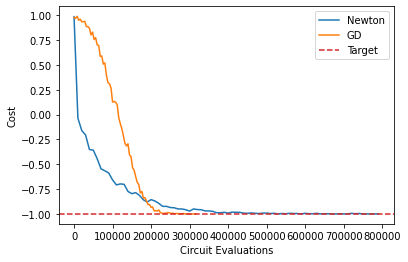

In [8]:
initial_point = np.array([0.1, 0.15])
s = 1000
circuit, op = paper_circuit_two_param()
q_instance = QuantumInstance(backend, shots=s)
sampler = CircuitSampler(q_instance)

gradient = Gradient(grad_method='param_shift').convert(op)
hessian = Hessian(hess_method='param_shift').convert(op)

gd_loss = []
x_values = []
# GD minimization
gd = GradientDescent(maxiter=80, learning_rate=0.1, tol=1e-4, callback=gd_callback)
x_opt, fx_opt, nfevs = gd.optimize(initial_point.size, evaluate_expectation, gradient_function=evaluate_gradient, \
                                   initial_point=initial_point) 

cir_evals = np.array([i for i in range(len(gd_loss))])
cir_evals *= (2 * circuit.num_parameters * s)

# 2nd order mimization 
newton = NewtonOpt(hessian, gradient, circuit.num_parameters, circuit, sampler, op, initial_point, maxiter=80)
loss, evals = newton.optimize()

plt.plot(evals, loss, label='Newton')
plt.plot(cir_evals, gd_loss, label='GD')
plt.axhline(-1, ls='--', c='tab:red', label='Target')
plt.ylabel('Cost')
plt.xlabel('Circuit Evaluations')
plt.legend()
plt.show()

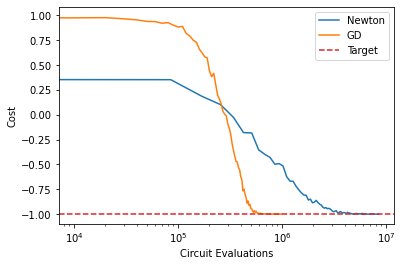

In [9]:
#initial_point = np.random.uniform(0, 2 * np.pi, 5)
initial_point = np.array([0.1, 0.15, 0, 0, 0])
s = 1000
circuit, op = paper_circuit()
q_instance = QuantumInstance(backend, shots=s)
sampler = CircuitSampler(q_instance)

gradient = Gradient().convert(op)
hessian = Hessian(hess_method='param_shift').convert(op)

gd_loss = []
x_values = []
# GD minimization
gd = GradientDescent(maxiter=100, learning_rate=0.1, tol=1e-4, callback=gd_callback)
x_opt, fx_opt, nfevs = gd.optimize(initial_point.size, evaluate_expectation, gradient_function=evaluate_gradient, \
                                   initial_point=initial_point) 

cir_evals = np.array([i for i in range(len(gd_loss))])
cir_evals *= (2 * circuit.num_parameters * s)

# 2nd order mimization 
newton = NewtonOpt(hessian, gradient, circuit.num_parameters, circuit, sampler, op, initial_point)
loss, evals = newton.optimize()

plt.plot(evals, loss, label='Newton')
plt.plot(cir_evals, gd_loss, label='GD')
plt.axhline(-1, ls='--', c='tab:red', label='Target')
plt.ylabel('Cost')
plt.xlabel('Circuit Evaluations')
plt.xscale('log')
plt.legend()
plt.show()